In [1]:
%%HTML
<style>
	@import url('https://fonts.googleapis.com/css2?family=JetBrains+Mono&display=swap');

	body {
		font-family: 'JetBrains Mono', -apple-system, BlinkMacSystemFont, 'Segoe WPC', 'Segoe UI', system-ui, 'Ubuntu', 'Droid Sans', sans-serif;
		line-height: 1.67;
	}
</style>

# Dynamic Periodic ETC for LPV Models under Saturation

_**[Event-based Control](https://github.com/andel-vitorio/event-based-control.git)**_

_by Andevaldo da Encarnação Vitório ([andevaldo.vitorio@icomp.ufam.edu.br](mailto:andevaldo.vitorio@icomp.ufam.edu.br)), last updated: April 20, 2025_

<!-- This notebook presents the implementation of the mathematical modeling and controller for a DC microgrid, represented by a buck converter with a CPL (Constant Power Load). The buck converter is a power conversion device that steps down a high DC voltage to a lower one. The CPL is a load that demands constant power regardless of variations in input voltage.

For the implementation, Python libraries such as Control, NumPy, and Matplotlib will be used. During implementation, the nonlinear system, shifted nonlinear system, and linearized system, all derived from the mathematical modeling, will be explored. -->

<!-- Detailed mathematical modeling can be found in the separate document titled ["Mathematical Modeling of a Microgrid"](../docs/Mathematical%20Modeling%20of%20a%20Microgrid.md), located in the `docs` directory.  -->

## 1. Importing Libraries

In [2]:
# Import modules for HTML display in the notebook and enable inline mode for Matplotlib
from IPython.display import display, HTML, Math, Latex
from IPython.core.magic import register_cell_magic
  
%matplotlib inline

# Import common libraries for data manipulation, optimization, and control
import pandas as pd  # type: ignore
import cvxpy as cp  # type: ignore
from matplotlib.ticker import FuncFormatter, MultipleLocator  # type: ignore
from control.matlab import *  # type: ignore
import control.optimal as opt  # type: ignore
import control as ct  # type: ignore
import matplotlib.pyplot as plt  # type: ignore
import numpy as np  # type: ignore
import matplotlib as mpl  # type: ignore
from matplotlib.patches import FancyArrowPatch # type: ignore
from scipy.integrate import quad # type: ignore
import importlib
import itertools
import csv
import concurrent.futures
from scipy.spatial import ConvexHull
import os
import json

from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

utils_path = os.path.abspath(os.path.join("..", "Utils"))
if utils_path not in sys.path:
    sys.path.append(utils_path)

# Import utility functions from custom modules
import Tex as tex
import Graphs as gph
import Signal as sgn
import Numeric as nm

importlib.reload(tex)
importlib.reload(gph)
importlib.reload(sgn)
importlib.reload(nm)

# Set the use of feedback standards for the control package
ct.use_fbs_defaults()

# Attempt to configure LaTeX for text rendering, otherwise use default Matplotlib fonts
gph.use_latex()

# Set the resolution of figures generated by Matplotlib
mpl.rcParams['figure.dpi'] = 100

@register_cell_magic
def skip(line, cell):
  return

LaTeX has been enabled for text rendering.


## 2. LPV Model

In [3]:
import numpy as np
import control as ct  # assuming control is being used for `nlsys`


def get_A(p):
  """
  Computes the A matrix for the system.

  Parameters
  ----------
  p : list or array
      The parameter values that define the system.

  Returns
  -------
  np.ndarray
      The A matrix for the system.
  """
  A11 = p[0]
  A12 = -1.0
  A21 = 1.0
  A22 = 0.0

  return np.array([[A11, A12],
                   [A21, A22]])


def get_B(p):
  """
  Computes the B matrix for the system.

  Parameters
  ----------
  p : list or array
      The parameter values that define the system.

  Returns
  -------
  np.ndarray
      The B matrix for the system.
  """
  B11 = 1.0
  B21 = 0.0
  return np.array([[B11],
                   [B21]])


def get_C(p):
  """
  Computes the C matrix for the system. In this case, it's fixed.

  Parameters
  ----------
  p : list or array
      The parameter values (not used here, kept for consistency).

  Returns
  -------
  np.ndarray
      The C matrix for the system.
  """
  return np.array([[0.0, 1.0]])


def plant_update(time, states, inputs, params):
  """
  Updates the plant state based on the current time, states, inputs, and parameters.

  Parameters
  ----------
  time : float
      The current time (not used in this version).
  states : np.ndarray
      The current states of the system.
  inputs : np.ndarray
      The current inputs to the system.
  params : dict
      The parameters, including amounts of states, parameters, and inputs.

  Returns
  -------
  np.ndarray
      The time derivative of the states (x_dot).
  """
  # Extracting the number of inputs and parameters
  n_u = params['amounts']['u']
  n_p = params['amounts']['p']

  # Splitting inputs into u (control inputs) and p (parameters)
  u = inputs[:n_u].reshape(-1, 1)
  p = inputs[n_u:n_u + n_p]

  # Reshaping the states into a column vector
  x = states.reshape(-1, 1)

  # Getting the system matrices A and B
  A = get_A(p)
  B = get_B(p)

  # Computing the time derivative of the states (x_dot)
  x_dot = A @ x + B @ u

  return x_dot


# Defining the system parameters
params = {
    "amounts": {'x': 2, 'p': 1, 'u': 1, 'w': 1}
}

# Defining the states and inputs dynamically based on params
states = [f'x{i+1}' for i in range(params["amounts"]['x'])]
inputs = ([f'u{i+1}' for i in range(params["amounts"]['u'])] +
          [f'p{i+1}' for i in range(params["amounts"]['p'])])

# Outputs are same as states for this example
outputs = states

# Assuming control library's nlsys function is used here
plant = ct.nlsys(plant_update, None, name="plant",
                 inputs=inputs, outputs=outputs, states=states)

# Printing the plant system
print(plant)

<NonlinearIOSystem>: plant
Inputs (2): ['u1', 'p1']
Outputs (2): ['x1', 'x2']
States (2): ['x1', 'x2']

Update: <function plant_update at 0x73fb2ab9ce00>
Output: None


## Predefinição da Simulação

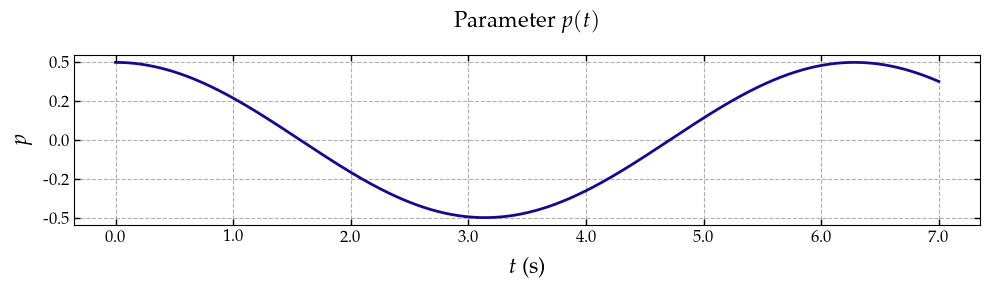

In [4]:
simulation_step = 1e-5
simulation_time = 7.
timepts = np.arange(0, simulation_time + simulation_step, simulation_step)

# Entrada para simulação em malha aberta
u = np.zeros((1, len(timepts)))

p = 0.5 * np.cos(timepts)

p_bounds = np.array([[-.5, .5]])

u_bar = [1.]

x_bounds = [(-1, 1.), (-1., 1.)]

X0 = [.5, .5]

fig = plt.figure(figsize=(10, 3), layout='constrained')
axs = fig.subplot_mosaic([["p"]])

gph.plot(axs['p'], timepts, p,
         xlabel='$t$ (s)', ylabel='$p$',
         title='Parameter $p(t)$',)

plt.tight_layout()

## Simulação da Planta em Malha Aberta

In [5]:
t, y = ct.input_output_response(
    sys=plant, T=timepts,
    U=[u, p,], X0=X0, params=params
)

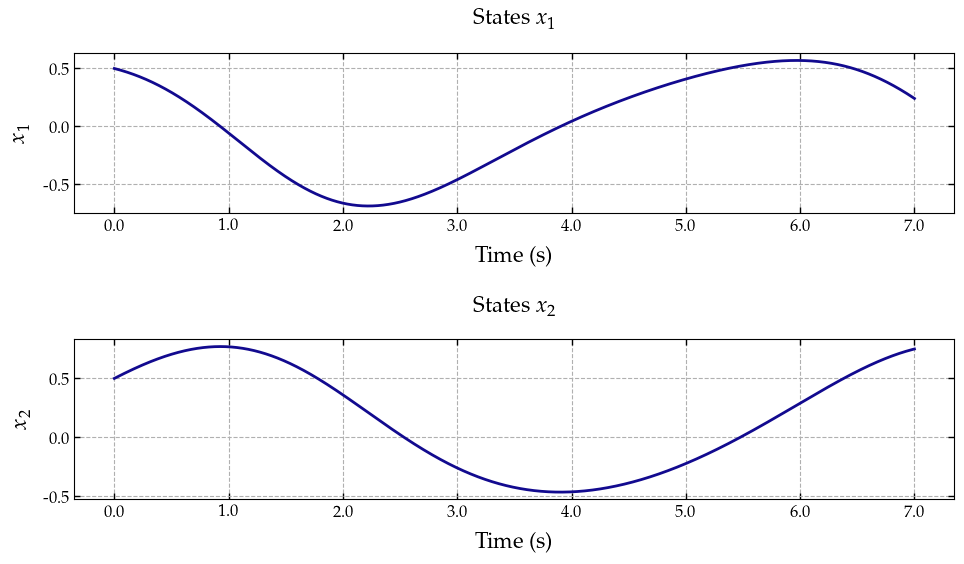

In [6]:
fig = plt.figure(figsize=(10, 6), layout='constrained')
axs = fig.subplot_mosaic([["x1"], ["x2"]])

for i in [0, 1]:
  gph.plot(axs[f'x{i+1}'], t, y[i],
           xlabel='Time (s)', ylabel=f'$x_{i+1}$',
           title=f'States $x_{i+1}$',)
plt.tight_layout(pad=2.)

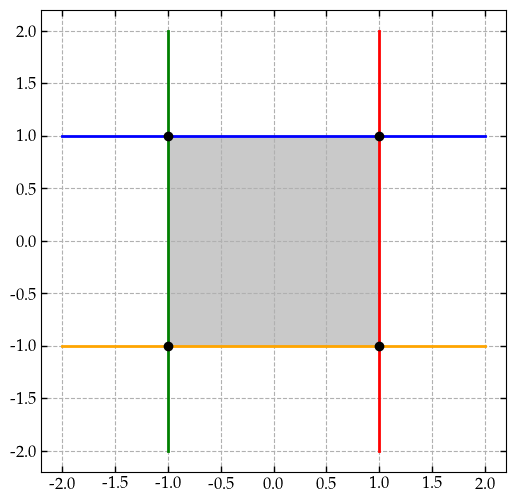

In [7]:
a_q = nm.get_vertices(x_bounds)
plot_data = nm.get_polyhedral_set(a_q, x_bounds)

# === Visualização do resultado ===

fig, ax = plt.subplots(figsize=(6, 6))
colors = ['red', 'green', 'blue', 'orange']

# Plot lines
for i, (x_vals, y_vals) in enumerate(plot_data["line_segments"]):
  gph.plot(ax, x_vals, y_vals, plot_cfg={'style': {'color': colors[i]}})

# Plot polygon (if it exists)
if plot_data["polygon_coords"] is not None:
  poly = plot_data["polygon_coords"]
  ax.fill(*poly.T, alpha=0.21, color='black', label="Intersection region")

# Plot intersection points
if plot_data["intersection_points"].size > 0:
  ax.scatter(*plot_data["intersection_points"].T, color='black', zorder=5)

In [8]:
def He(M): return M + M.T


def get_parameter(h, λ, ε, eps=1e-6):

  n_u = params['amounts']['u']
  n_p = params['amounts']['p']
  n_x = params['amounts']['x']

  Bnp = list(itertools.product([0, 1], repeat=n_p))
  Onx = np.zeros((n_x, n_x))
  O2nx = np.zeros((2 * n_x, 2 * n_x))

  aq = nm.get_vertices(x_bounds)

  A = {}
  B = {}

  for i in Bnp:
    pi = [p_bounds[idx][i[idx]] for idx in range(n_p)]
    A[i] = cp.Parameter((n_x, n_x), name=f'A[{i}]', value=get_A(pi))
    B[i] = cp.Parameter((n_x, n_u), name=f'B[{i}]', value=get_B(pi))

  e = {}
  _es = np.eye(n_x)
  _ef = np.zeros((n_x, 6 * n_x))
  e[1] = np.block([[_es, _ef, np.zeros((n_x, n_u))]])
  e[7] = np.block([[_ef, _es, np.zeros((n_x, n_u))]])

  for i in range(2, 7):
    e[i] = np.block([[np.zeros((n_x, n_x * (i - 1))),
                      np.eye(n_x),
                      np.zeros((n_x, n_x * (7 - i))),
                      np.zeros((n_x, n_u))]])

  e[8] = np.block([[np.zeros((n_u,  7 * n_x)), np.eye(n_u)]])

  for i in range(1, 9):
    e[i] = cp.Parameter(e[i].shape, value=e[i], name=f"e{i}")

  Ptil = cp.Variable((n_x, n_x), PSD=True)
  Stil = cp.Variable((n_x, n_x), PSD=True)
  Mtil = cp.Variable((n_x, n_x), PSD=True)

  Pcal = cp.bmat([[Ptil,   Mtil],
                  [Mtil.T, Stil]])

  constraints = []

  Ktil = {}
  Gcal = {}
  ℵ = {}

  for i in Bnp:
    Ktil[i] = cp.Variable((n_u, n_x), name=f'K[{i}]')
    Gcal[i] = cp.Variable((n_u, n_x))
    ℵ[i] = cp.Variable((n_u, n_u), diag=True)
    constraints += [ℵ[i] >> 0]

  Qtil = cp.Variable((n_x, n_x), PSD=True)
  Rtil = cp.Variable((n_x, n_x), PSD=True)
  Ξtil = cp.Variable((n_x, n_x), PSD=True)
  Ψtil = cp.Variable((n_x, n_x), PSD=True)
  β = cp.Variable(pos=True)
  ρ = cp.Variable(pos=True)

  X = cp.Variable((n_x, n_x))
  Y1til = cp.Variable((2 * n_x, 2 * n_x))
  Y2til = cp.Variable((2 * n_x, 2 * n_x))

  Rcal = cp.bmat([[Rtil, Onx],
                  [Onx, 3. * Rtil]])

  N = e[1].T + λ * e[2].T + λ * e[3].T

  Π = cp.bmat([[e[1] - e[3]],
              [e[1] + e[3] - 2 * e[5]],
              [e[3] - e[4]],
              [e[3] + e[4] - 2 * e[6]]])

  κ1 = {}
  κ1['0'] = cp.bmat([[e[1]], [h * e[6]]])
  κ1['h'] = cp.bmat([[e[1]], [h * e[5]]])

  κ2 = cp.bmat([[e[2]], [e[1] - e[4]]])

  def get_Λ(i, j):
    Ytil = A[i] @ X @ e[1] - X @ e[2] + \
        B[i] @ Ktil[j] @ e[3] + B[i] @ Ktil[j] @ e[7] - \
        B[i] @ ℵ[j] @ e[8]

    Θtil = {}
    Θtil['0'] = 2 * κ1['0'].T @ Pcal @ κ2 + h * e[1].T @ Qtil @ e[1] - \
        h * e[4].T @ Qtil @ e[4] + (h ** 2) * e[2].T @ Rtil @ e[2] - \
        e[7].T @ Ξtil @ e[7] + He(N @ Ytil) - \
        2. * e[8].T @ ℵ[j] @ e[8] + 2. * \
        e[8].T @ Gcal[j] @ e[3] + 2. * e[8].T @ Gcal[j] @ e[7]

    Θtil['h'] = 2 * κ1['h'].T @ Pcal @ κ2 + h * e[1].T @ Qtil @ e[1] - \
        h * e[4].T @ Qtil @ e[4] + (h ** 2) * e[2].T @ Rtil @ e[2] - \
        e[7].T @ Ξtil @ e[7] + He(N @ Ytil) - \
        2. * e[8].T @ ℵ[j] @ e[8] + 2. * \
        e[8].T @ Gcal[j] @ e[3] + 2. * e[8].T @ Gcal[j] @ e[7]

    Φtil = {}

    Φtil1 = cp.bmat([[Rcal, O2nx],
                    [O2nx, Rcal]])
    Φtil2 = cp.bmat([[Rcal, Y2til], [Y2til.T, O2nx]])
    Φtil3 = cp.bmat([[O2nx, Y1til], [Y1til.T, Rcal]])

    Φtil['0'] = Φtil1 + Φtil2
    Φtil['h'] = Φtil1 + Φtil3

    Γ1_11 = Θtil['0'] - Π.T @ Φtil['0'] @ Π
    Γ1_12 = Π.T @ cp.bmat([[Y1til], [O2nx]])
    Γ1_13 = e[3].T @ X.T

    Γ1_21 = Γ1_12.T
    Γ1_22 = - Rcal
    Γ1_23 = np.zeros((2 * n_x, n_x))

    Γ1_31 = Γ1_13.T
    Γ1_32 = Γ1_23.T
    Γ1_33 = - Ψtil

    Γ1 = cp.bmat([[Γ1_11, Γ1_12, Γ1_13],
                  [Γ1_21, Γ1_22, Γ1_23],
                  [Γ1_31, Γ1_32, Γ1_33],])

    Γ2_11 = Θtil['h'] - Π.T @ Φtil['h'] @ Π
    Γ2_12 = Π.T @ cp.bmat([[O2nx], [Y2til.T]])
    Γ2_13 = e[3].T @ X.T

    Γ2_21 = Γ2_12.T
    Γ2_22 = - Rcal
    Γ2_23 = np.zeros((2 * n_x, n_x))

    Γ2_31 = Γ2_13.T
    Γ2_32 = Γ2_23.T
    Γ2_33 = - Ψtil

    Γ2 = cp.bmat([[Γ2_11, Γ2_12, Γ2_13],
                  [Γ2_21, Γ2_22, Γ2_23],
                  [Γ2_31, Γ2_32, Γ2_33],])

    return Γ1, Γ2

  binary_pairs = nm.binary_pairs(n_p)

  for pairs in binary_pairs:
    LMI_ST = {}
    LMI_ST['0'], LMI_ST['h'] = 0., 0.

    for pair in pairs:
      Λ = {}
      Λ['0'], Λ['h'] = get_Λ(pair[0], pair[1])
      LMI_ST['0'] += Λ['0']
      LMI_ST['h'] += Λ['h']

    constraints += [LMI_ST['0'] << -eps * np.eye(LMI_ST['0'].shape[0])]
    constraints += [LMI_ST['h'] << -eps * np.eye(LMI_ST['0'].shape[0])]

  v = {}
  v[1] = np.block([[np.eye(2 * n_x), np.zeros((2 * n_x, n_x))]])
  v[2] = np.block([[np.zeros((n_x, 2 * n_x)), np.eye(n_x)]])

  for ell in range(n_u):
    for j in Bnp:
      LMISAT_11 = Ptil + (h ** 2) * Stil + h * (Qtil + Mtil + Mtil.T)
      LMISAT_12 = (Ktil[j][ell:ell+1] - Gcal[j][ell:ell+1]).T

      LMISAT_21 = LMISAT_12.T
      LMISAT_22 = β * (u_bar[ell] ** 2) * np.eye(1)

      LMISAT = cp.bmat([[LMISAT_11, LMISAT_12],
                        [LMISAT_21, LMISAT_22],])

      constraints += [LMISAT >> 0.]

  for i in range(4):
    LMI_INC_11 = β * np.eye(1)
    LMI_INC_12 = ρ * aq[i].T
    LMI_INC_21 = LMI_INC_12.T
    LMI_INC_22 = X.T + X - Ptil

    LMI_INC = cp.bmat([[LMI_INC_11,   LMI_INC_12],
                       [LMI_INC_21,  LMI_INC_22]])

    constraints += [LMI_INC >> 0.]

  constraints += [Pcal >> 0.]
  constraints += [(h ** 2) * Stil + h * (Qtil + Mtil + Mtil.T) << 0.]
  constraints += [ρ >= ε]

  obj = cp.Minimize(cp.trace(Ξtil + Ψtil) + β)
  prob = cp.Problem(obj, constraints)

  # Solve the problem using the MOSEK solver
  prob.solve(solver=cp.MOSEK, verbose=False, ignore_dpp=True)

  # Initialize variables to store results
  design_results = None

  # Display the results
  if prob.status not in ["infeasible", "unbounded"]:
    # print("Optimal value: %s\n" % prob.value)

    # matrix_utils.show_matrix(Ξtil.value, 'Ξtil')

    Xinv = np.linalg.inv(X.value)
    Ξ = Xinv.T @ Ξtil.value @ Xinv
    Ψ = np.linalg.inv(Ψtil.value)

    # matrix_utils.show_matrix(Xinv.T @ Ξtil.value)

    # matrix_utils.show_matrix(X.value, 'X')

    P = Xinv.T @ Ptil.value @ Xinv
    M = Xinv.T @ Mtil.value @ Xinv
    S = Xinv.T @ Stil.value @ Xinv
    Q = Xinv.T @ Qtil.value @ Xinv
    R = Xinv.T @ Rtil.value @ Xinv

    Pcal_ = np.block([[P, M], [M.T, S]])

    # matrix_utils.show_matrix(Ptil.value, 'Ptil')

    P_eig = np.linalg.eig(P)[0]
    S_eig = np.linalg.eig(S)[0]
    Pcal_eig = np.linalg.eig(Pcal_)[0]

    error = False

    for i in range(n_x):
      if P_eig[i] <= 0:
        # print("P não é definida positiva!")
        error = True
      if S_eig[i] <= 0:
        # print("S não é definida positiva!")
        error = True

    # print('Autovalores de Pcal: ', Pcal_eig)
    for eig in Pcal_eig:
      if eig <= 0:
        # print("Pcal não é definida positiva!")
        error = True

    if error == False:
      K = {}
      G = {}
      for i in Bnp:
        K[i] = Ktil[i].value @ Xinv
        G[i] = Gcal[i].value @ Xinv
        # matrix_utils.show_matrix(K[i], f'K{i}')

      # matrix_utils.show_matrix(Ξ, 'Ξ')
      # matrix_utils.show_matrix(Ψ, 'Ψ')

      design_results = {
          'optimal_value': prob.value,
          'etm': {'Ξ': Ξ, 'Ψ': Ψ},
          'controller': {'K': K, 'G': G},
          'lyapunov': {'P': P, 'M': M, 'S': S, 'Q': Q, 'R': R},
          'bounds': {'β': β.value, 'ρ': ρ.value}
      }
  else:
    # print('The problem is not feasible')
    design_results = None

  return design_results

In [9]:
%%skip

# Definir a escala logarítmica dos parâmetros
ε1_values = np.logspace(-6, -1, num=150)  # Epsilon de γ
ε2_values = np.logspace(-6, -1, num=150)  # Epsilon de ρ

δ = 0.2
h = 10e-3
λ = 1e-2

# Lista para armazenar os resultados
opt_prob_results = []

# Função para executar no pool de processos


def evaluate_parameters(args):
  ε1, ε2 = args
  try:
    epsilon_bounds = [ε1, ε2]
    design_results = get_parameter(h, λ, δ, epsilon_bounds)
    if design_results is not None:
      bounds = design_results['bounds']
      return (bounds['γ'], bounds['ρ'], bounds['β'], design_results['optimal_value'])
  except:
    pass
  return None


# Criando a lista de combinações dos parâmetros
param_combinations = [(ε1, ε2) for ε1 in ε1_values for ε2 in ε2_values]

# Executando em paralelo
with concurrent.futures.ProcessPoolExecutor() as executor:
  for result in executor.map(evaluate_parameters, param_combinations):
    if result is not None:
      opt_prob_results.append(result)

print(len(opt_prob_results), 'tuplas de parâmetros foram factíveis!')

In [10]:
%%skip

# Definir os dados
X = res_array[:, 0]
Y = res_array[:, 1]
Z_beta = res_array[:, 2]
Z_trace = res_array[:, 3] - res_array[:, 2]

# Definir os limites desejados para X e Y
x_min, x_max = 0., 0.3

# Definir os rótulos dos gráficos
labels_beta = ['$\\gamma$', '$\\rho$', '$\\beta$']
labels_trace = ['$\\gamma$', '$\\rho$', 'tr$(\\tilde \\Xi + \\tilde \\Psi)$']

# Gerar os gráficos
gph.plot_2d_projection(X, Y, Z_beta, x_min=x_min, x_max=x_max,
                       labels=labels_beta)
gph.plot_2d_projection(X, Y, Z_trace, x_min=x_min, x_max=x_max
                       labels=labels_trace)

In [11]:
design_results = get_parameter(h=10e-3, λ=1e-2, ε=1e-2)

Ξ = None
Ψ = None
K = None
G = None
P = None
M = None
S = None
Q = None
R = None
ρ = None
γ = None
β = None

if design_results is not None:
  Ξ = design_results['etm']['Ξ']
  Ψ = design_results['etm']['Ψ']
  K = design_results['controller']['K']
  G = design_results['controller']['G']
  P = design_results['lyapunov']['P']
  M = design_results['lyapunov']['M']
  S = design_results['lyapunov']['S']
  Q = design_results['lyapunov']['Q']
  R = design_results['lyapunov']['R']
  ρ = design_results['bounds']['ρ']
  β = design_results['bounds']['β']

  print('Resultados:')
  display(Math(rf'f^\star =' + tex.dec2tex(design_results['optimal_value'])))
  display(Math(rf'\beta =' + tex.dec2tex(β)))
  display(Math(rf'\rho =' + tex.dec2tex(ρ)))
  display(Math(rf'x^\top(t) P x(t) \preceq' + tex.dec2tex(1. / β)))

  # display(Math(rf'P = ' + dp.mat2tex(P)))

  print('Matrizes de Acionamento:')
  display(Math(rf'\Xi = ' + tex.mat2tex(Ξ)))
  display(Math(rf'\Psi = ' + tex.mat2tex(Ψ)))

  print('Matrizes de Controle:')
  B1 = list(itertools.product([0, 1], repeat=1))
  for i in B1:
    i_tex = "".join(map(str, i))
    display(Math(rf'K_{i_tex} = ' + tex.mat2tex(K[i])))
    display(Math(rf'G_{i_tex}= ' + tex.mat2tex(G[i])))
else:
  print('Problema não é factível!')

Resultados:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Matrizes de Acionamento:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

Matrizes de Controle:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

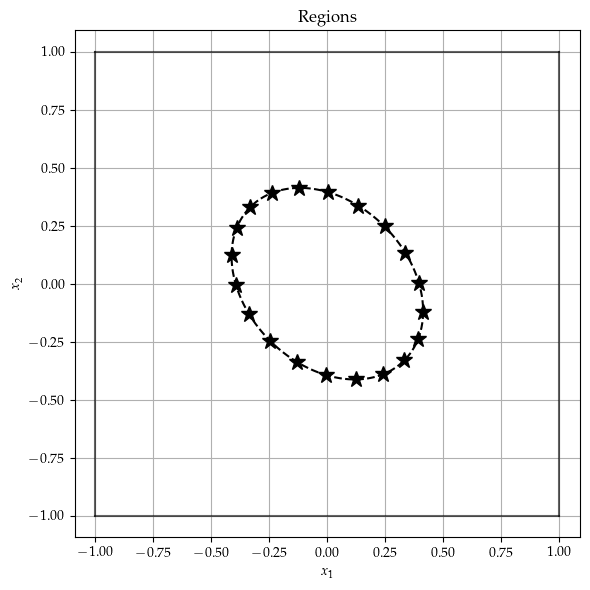

In [12]:
%matplotlib inline

# Definindo intervalo de plotagem
x1_range = (-0.6, 0.6)
x2_range = (-1., 1.)
num_points = 20
h = 10e-3

# Supondo que nm.get_polyhedral_set(a_q, x_bounds) já tenha sido calculado
intersection_points = nm.get_polyhedral_set(a_q, x_bounds)['intersection_points']

# Iniciando a figura para o gráfico
fig, ax = plt.subplots(1, 1, figsize=(6., 6.))

# Verifica se há pontos de interseção
if intersection_points.size > 0:
    try:
        # Calcula o ConvexHull dos pontos de interseção
        hull = ConvexHull(intersection_points)

        # Plota as bordas (arestas) do poliedro
        for simplex in hull.simplices:
            ax.plot(intersection_points[simplex, 0], intersection_points[simplex, 1], 'k-', alpha=0.6)
    except:
        print("Unable to compute ConvexHull or plot the polyhedron edges.")

initial_states_list = nm.ellipsoid_boundary_points(P, (1. / β),
                                                   num_points)
plt.plot(initial_states_list[0], initial_states_list[1], '*',
         linestyle='None', c='black', markersize=12)

D0 = nm.get_ellipsoid_boundary(P, (1. / β))
# plt.plot(D0['x1_vals'], D0['x2_vals'], 
#          'k-', label='Ellipsoid Boundary')

# Função V 
def compute_V(X1, X2, P, M, S, Q, h):
    V_values = np.zeros_like(X1)
    for i in range(X1.shape[0]):
        for j in range(X1.shape[1]):
            x = np.array([X1[i, j], X2[i, j]])
            ξ = np.hstack((x, h * x))
            Pcal = np.block([[P, M], [M.T, S]])
            V1 = ξ.T @ Pcal @ ξ

            integral_1 = h * x.T @ Q @ x
            integral_2 = ((h ** 3) / 2.) * x.T @ R @ x

            V2 = integral_1 + integral_2
            V_values[i, j] = V1 + V2
    return V_values

X1, X2, V_values, contour_data = nm.get_region_boundary(
    lambda X1, X2: compute_V(X1, X2, P, M, S, Q, h), 
    x1_range=x1_range, x2_range=x2_range, num_points=100
)

plt.contour(X1, X2, V_values, levels=[1. / β], 
            colors='black', linestyles='--')

# Ajustes finais de layout
ax.set_title("Regions")
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.grid(True)
ax.axis('equal')

# Exibir o gráfico
plt.tight_layout()

In [13]:
class DynamicETM:
  def __init__(self, name, Ψ, Ξ, θ, λ, T):
    self.name = name
    self.previous_time = 0
    self.first_simulation = True
    self.event_times = [0.]
    self.next_sampling_time = 0.
    self.last_time = 0.
    self.last_sampled_states = []
    self.last_printed_sampling_time = -1.

    # Matrizes de Acionamento
    self.Ξ = Ξ
    self.Ψ = Ψ
    self.T = T

    self.θ = θ
    self.λ = λ
    self.system = ct.NonlinearIOSystem(
        self.etm_update, self.etm_output,
        name=self.name, states=['n'],
        inputs=['x1_hat', 'x2_hat', 'x1', 'x2', 'p1_hat', 'p1'],
        outputs=['n', 'x1', 'x2', 'p1']
    )

  def etm_update(self, t, n, u, params):
    # Obtenção do último estado transmitido e o estado atual
    x_hat = np.array(u[0:2]).reshape(-1, 1)
    x = np.array(u[2:4]).reshape(-1, 1)

    # Verifica se ocorrerá um novo evento de transmissão
    new_event = False
    is_sampling_instant = False
    if t >= self.next_sampling_time:
      ε = x_hat - x
      Tcal = x.T @ self.Ψ @ x - ε.T @ self.Ξ @ ε
      new_event = n[0] + self.θ * Tcal < 0
      is_sampling_instant = True

    # Obtenção do x(t - τ)
    xτ = self.last_sampled_states  # Para t != nh
    if is_sampling_instant:
      xτ = x.copy()                # Para t == nh

    # Verifica a atualização de x_hat e ε
    ε = x_hat - xτ
    if new_event == True or t == 0.:
      x_hat = x.copy()
      ε = np.zeros((2, 1))

    # Atualiza a variável dinâmica
    Tcal = xτ.T @ self.Ψ @ xτ - ε.T @ self.Ξ @ ε
    n_dot = - self.λ * n + Tcal

    return n_dot

  def etm_output(self, t, n, u, params):
    if t != self.previous_time:
      if self.previous_time >= self.next_sampling_time:
        self.next_sampling_time += self.T

      if self.first_simulation and t == 0.:
        self.first_simulation = False
        self.previous_time = 0
        self.last_printed_sampling_time = -1.

      if t == 0.:
        self.last_time = 0.
        self.next_sampling_time = 0.
      elif t < self.previous_time:
        assert 'Integração Retrógrada'

      self.previous_time = t

    x_hat = np.array(u[0:2]).reshape(-1, 1)
    x = np.array(u[2:4]).reshape(-1, 1)
    p_hat = u[4:5]
    p = u[5:6]

    new_event = False

    if (t >= self.next_sampling_time):
      if (t != self.last_printed_sampling_time):
        # print(f'Sampling Time: {t:.3f}')
        self.last_printed_sampling_time = t

      ε = x_hat - x
      Tcal = x.T @ self.Ψ @ x - ε.T @ self.Ξ @ ε
      new_event = (n[0] + self.θ * Tcal < 0.) or (t == 0.)
      self.last_sampled_states = x

    if self.first_simulation and new_event and self.event_times[-1] != t:
      # print('Event Time: ', t)
      self.event_times.append(t)

    x_to_send = x if new_event else x_hat
    p_to_send = p if new_event else p_hat

    return np.concatenate((n, x_to_send.reshape(-1), p_to_send))

In [14]:
class ZeroOrderHold:
  def __init__(self):
    self.previous_time = 0
    self.previous = []
    self.last_samples_sent = [0., 0., 0.]
    self.system = ct.nlsys(
        None, self.zoh_output,
        name='zoh',
        inputs=['x1', 'x2', 'p1'],
        outputs=['x1_hat', 'x2_hat', 'p1_hat'],
    )

  def zoh_output(self, t, x, u, params):
    if t != self.previous_time:
      self.last_samples_sent = self.previous
      self.previous_time = t
    self.previous = u
    return self.last_samples_sent


class Controller:
  def __init__(self, K):
    self.K = K
    self.system = ct.nlsys(
        None, self.control_output,
        name='controller',
        inputs=['x1_hat', 'x2_hat', 'p1_hat'],
        outputs=['u1'],
    )

  def control_output(self, t, x, u, params):
    x_hat = np.array(u[0:2]).reshape(-1, 1)
    p1_hat = u[2]

    α_1 = (p_bounds[0][1] - p1_hat) / (p_bounds[0][1] - p_bounds[0][0])
    α_0 = 1. - α_1

    u = α_1 * K[(0,)] @ x_hat + α_0 * K[(1,)] @ x_hat

    return np.array([[sgn.sat(u[0][0], u_bar[0])]])

In [15]:
# Nome do arquivo de experimento
experiment_name = "Results/1/Trajectories-N1.json"
h = 10e-3
λ = 1e-3
# Define se as simulações devem ser forçadas mesmo se o arquivo já existir
force_simulation = False
simulations_amount = 1

# Estrutura para armazenar os resultados
results_clsim = {
    'trajectories': [],
    'inter-event-times': []
}

# Verificar se o arquivo já existe
if os.path.exists(experiment_name) and not force_simulation:
  print(f"O arquivo {experiment_name} já existe. Carregando dados salvos.")
  with open(experiment_name, "r") as f:
    results_clsim = json.load(f)
else:
  def get_trajectories(i):
    θ = (1. / λ) * (np.exp(λ * h) - 1.)

    etm = DynamicETM('etm', Ψ, Ξ, θ, λ, h)
    zoh = ZeroOrderHold()
    controller = Controller(K)

    closed_loop = ct.interconnect(
        (plant, etm.system, zoh.system, controller.system),
        connections=[
            ['plant.u1', 'controller.u1'],

            ['etm.x1_hat', 'zoh.x1_hat'],
            ['etm.x2_hat', 'zoh.x2_hat'],
            ['etm.p1_hat', 'zoh.p1_hat'],

            ['etm.x1', 'plant.x1'],
            ['etm.x2', 'plant.x2'],

            ['zoh.x1', 'etm.x1'],
            ['zoh.x2', 'etm.x2'],
            ['zoh.p1', 'etm.p1'],

            ['controller.x1_hat', 'zoh.x1_hat'],
            ['controller.x2_hat', 'zoh.x2_hat'],
            ['controller.p1_hat', 'zoh.p1_hat'],
        ],
        name='closed-loop system',
        inplist=['plant.p1', 'etm.p1'],
        outlist=['etm.n', 'plant.x1', 'plant.x2', 'controller.u1'],
    )

    etm.event_times = [0.]

    _, trajectories = ct.input_output_response(
        sys=closed_loop, T=timepts,
        U=[p, p],
        X0=[initial_states_list[0][i], initial_states_list[1][i], 0.],
        params=params,
        solve_ivp_method='RK45',
        solve_ivp_kwargs={'max_step': simulation_step,
                          'first_step': simulation_step,
                          'atol': 1e-2, 'rtol': 1e-2},
    )

    inter_event_times = np.diff(etm.event_times).tolist()

    return {'trajectories': trajectories.tolist(), 'inter-event-times': inter_event_times}

  # Paralelismo com ProcessPoolExecutor
  with concurrent.futures.ProcessPoolExecutor() as executor:
    results = list(executor.map(get_trajectories,
                                range(simulations_amount)))

  # Atualizar estrutura de resultados
  for res in results:
    results_clsim['trajectories'].append(res['trajectories'])
    results_clsim['inter-event-times'].append(res['inter-event-times'])

  # Salvar resultados em um arquivo JSON
  with open(experiment_name, "w") as f:
    json.dump(results_clsim, f, indent=4)

  print(f"Simulações concluídas. Resultados salvos em {experiment_name}.")

O arquivo Results/1/Trajectories-N1.json já existe. Carregando dados salvos.


In [16]:
B1 = nm.binary_set(1)
u_max = u_bar[0]

x_vals = np.linspace(-.5, .5, 200)
y_vals = np.linspace(-1, 1, 200)

X, Y = np.meshgrid(x_vals, y_vals)
points = np.vstack([X.ravel(), Y.ravel()]).T

valid_points = np.ones(X.shape, dtype=bool)

for b in B1:
  K_b = K[b]
  G_b = G[b]
  K_minus_G = K_b - G_b
  result = np.abs(np.dot(points, K_minus_G.T))
  valid_points &= (result.reshape(X.shape) <= u_max)

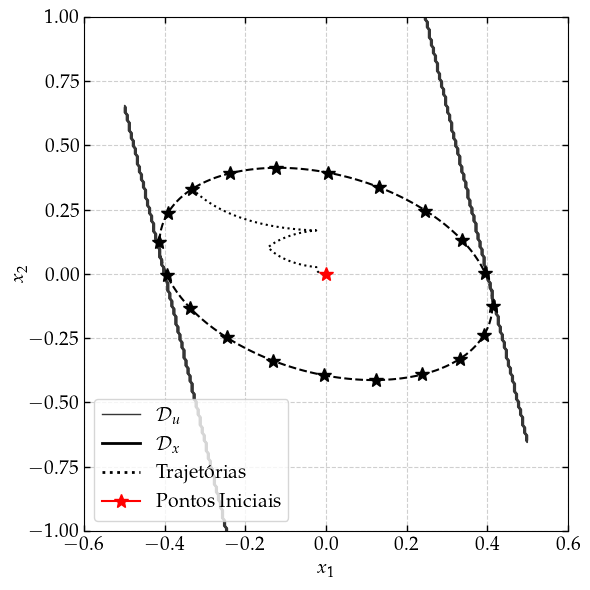

In [17]:
%matplotlib inline

x1_range = (-.5, .5)
x2_range = (-.5, .5)

trajectories = results_clsim['trajectories']

fig, ax = plt.subplots(1, 1, figsize=(6., 6.))
fig.canvas.manager.set_window_title(
    "Região de Estabilidade Externa/Estados Iniciais Admissíveis")

ax.contour(X1, X2, V_values, levels=[1. / β], 
            colors='black', linestyles='--')


for trajectory in trajectories:
  ax.plot(trajectory[1], trajectory[2], color='black', linestyle=':')

contour = ax.contour(X, Y, valid_points, 
                     colors='#363636', linewidths=1.)

ax.plot(initial_states_list[0], initial_states_list[1], '*',
         linestyle='None', c='black', markersize=10)

ax.set_xlabel("$x_1$", fontsize=14)
ax.set_ylabel("$x_2$", fontsize=14, labelpad=0.)
ax.tick_params(axis='both', direction='in', length=4, width=1,
               colors='black', top=True, right=True, labelsize=14)
ax.grid(True, linestyle='--', alpha=0.6)


elements = [
    ('line', {'color': '#363636', 'linestyle': '-', 'linewidth': 1.}),
    ('line', {'color': 'black', 'linestyle': '-', 'linewidth': 2.}),
    ('line', {'color': 'black', 'linestyle': ':', 'linewidth': 2.}),
    ('marker', {'marker': '*', 'color': 'red', 'markersize': 10})
]

labels = ['${\\cal D}_u$', '${\\cal D}_x$', 
          'Trajetórias', 'Pontos Iniciais']

gph.create_custom_legend(ax, elements, labels)

plt.tight_layout()

Estados Inicial:  0.3312563510464225
Número de Eventos Acionados:  4
Menor IET Obtido:  0.7399980000027385
Máximo IET Obtido:  2.2300019999861873
Média do Intervalos de Tempo entre Eventos:  1.160000499998377


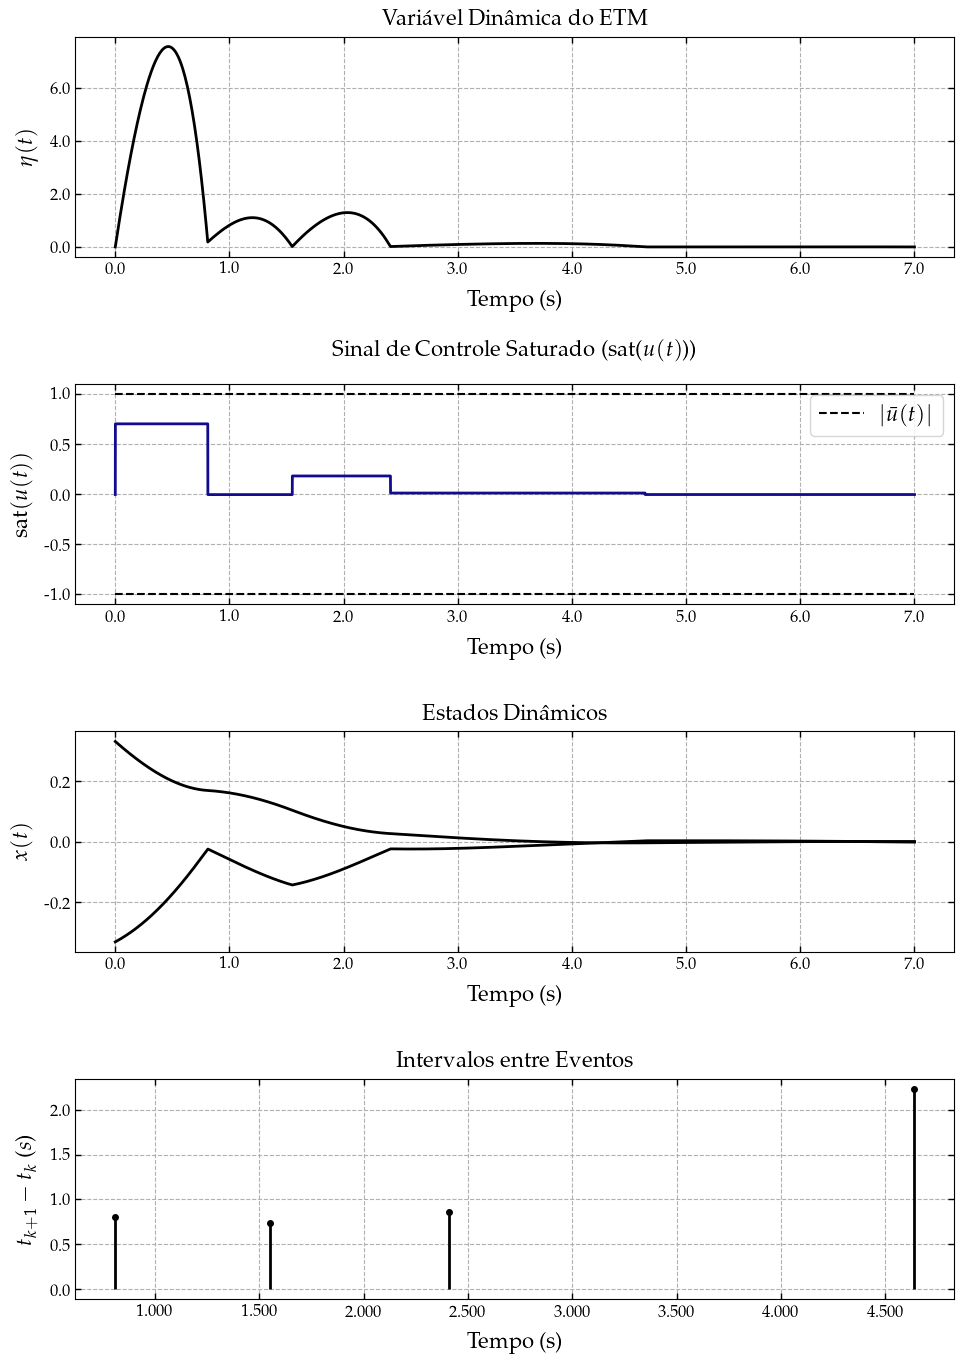

In [20]:
%matplotlib inline

fig, axs = plt.subplot_mosaic([['η'], ['sat'], ['x'], ['iet']], 
                              figsize=(10, 14))

trajectories = results_clsim['trajectories']
trajectories_index = 0


inter_event_times = results_clsim['inter-event-times'][trajectories_index]
event_times = np.cumsum(inter_event_times)

print("Estados Inicial: ", trajectories[trajectories_index][2][0])
print("Número de Eventos Acionados: ", len(inter_event_times))
print("Menor IET Obtido: ", min(inter_event_times))
print("Máximo IET Obtido: ", max(inter_event_times))
print("Média do Intervalos de Tempo entre Eventos: ", np.mean(
      inter_event_times) )

plot_cfg = {
  'style': { 'color': 'black', },
  'axis': { 'title_pad': 8, 'y_digits': 1 },
  'limits': { 'x_min': 0.0, 'y_min': simulation_time }
}

gph.plot(
    axs['η'], t, trajectories[trajectories_index][0],
    xlabel='Tempo (s)', ylabel='$\\eta(t)$',
    title='Variável Dinâmica do ETM',
    plot_cfg=plot_cfg)

axs['sat'].hlines([1., -1], 0, 7, colors='black', linestyles='--', label='$|\\bar u(t)|$')
axs['sat'].legend(prop={'size': 16})

gph.plot(
    axs['sat'], t, trajectories[trajectories_index][3],
    xlabel='Tempo (s)', ylabel='sat$(u(t))$',
    title='Sinal de Controle Saturado (sat($u(t)$))',)

gph.plot(
    axs['x'],
    t, trajectories[trajectories_index][1],
    xlabel='Tempo (s)', ylabel='$x_1(t)$',
    plot_cfg=plot_cfg)

gph.plot(
    axs['x'],
    t, trajectories[trajectories_index][2],
    xlabel='Tempo (s)', ylabel='$x(t)$',
    title='Estados Dinâmicos',
    plot_cfg=plot_cfg)

gph.stem(
     axs['iet'], [et for et in event_times],
    [et for et in inter_event_times],
    stem_cfg=plot_cfg,
    xlabel='Tempo (s)', ylabel='$t_{k+1} - t_k$ ($s$)',
    title='Intervalos entre Eventos')

plt.tight_layout(pad=2.)

In [19]:
# import concurrent.futures
# import numpy as np
# import control as ct
# import os
# import json
# import itertools
# import pandas as pd

# # Nome do arquivo de experimento
# experiment_name = "CLSim_ETMParameters_23fev2025_Exp1.json"

# # Definição dos parâmetros
# upsilon_values = [1e-2, 1e0, 1e2]
# theta_values = [1e-2, 1e-1, 1e0, 1e1, 1e2]

# # Gerar combinações de upsilon e theta
# upsilon_theta_pairs = list(itertools.product(upsilon_values, theta_values))

# # Estrutura para armazenar os resultados
# results_clsim_etm = {
#     'upsilon_theta': [],
#     'inter-event-times': [],
#     'experiment_parameters': {
#         'upsilon_values': upsilon_values,
#         'theta_values': theta_values,
#         'upsilon_theta_pairs': upsilon_theta_pairs,
#     }
# }

# # Função para obter trajetórias


# def get_trajectories(args):
#   upsilon, theta = args
#   etm = DynamicETM('etm', Ψ, Ξ, theta, upsilon, h)
#   zoh = ZeroOrderHold()
#   controller = Controller(K)

#   closed_loop = ct.interconnect(
#       (plant, etm.system, zoh.system, controller.system),
#       connections=[
#           ['plant.u1', 'controller.u1'],

#           ['etm.x1_hat', 'zoh.x1_hat'],
#           ['etm.x2_hat', 'zoh.x2_hat'],
#           ['etm.p1_hat', 'zoh.p1_hat'],

#           ['etm.x1', 'plant.x1'],
#           ['etm.x2', 'plant.x2'],

#           ['zoh.x1', 'etm.x1'],
#           ['zoh.x2', 'etm.x2'],
#           ['zoh.p1', 'etm.p1'],

#           ['controller.x1_hat', 'zoh.x1_hat'],
#           ['controller.x2_hat', 'zoh.x2_hat'],
#           ['controller.p1_hat', 'zoh.p1_hat'],
#       ],
#       name='closed-loop system',
#       inplist=['plant.p1', 'etm.p1'],
#       outlist=['etm.n', 'plant.x1', 'plant.x2', 'controller.u1'],
#   )

#   etm.event_times = [0.]

#   _, trajectories = ct.input_output_response(
#       sys=closed_loop, T=timepts,
#       U=[p1, p1],
#       X0=[contour_points[0][0], contour_points[1][0], 0.],  # Ponto inicial fixo
#       params=params,
#       solve_ivp_method='RK45',
#       solve_ivp_kwargs={'max_step': simulation_step,
#                         'first_step': simulation_step,
#                         'atol': 1e-2, 'rtol': 1e-2},
#   )

#   inter_event_times = np.diff(etm.event_times).tolist()
#   avg_inter_event_time = np.mean(
#       inter_event_times) if inter_event_times else 0

#   return {'upsilon': upsilon, 'theta': theta, 'avg_inter_event_time': avg_inter_event_time}


# # Verificar se o arquivo já existe
# if os.path.exists(experiment_name):
#   with open(experiment_name, "r") as f:
#     results_clsim_etm = json.load(f)
# else:
#   # Executar experimentos se o arquivo não existir
#   with concurrent.futures.ProcessPoolExecutor() as executor:
#     results = list(executor.map(get_trajectories, upsilon_theta_pairs))

#   # Atualizar estrutura de resultados
#   for res in results:
#     results_clsim_etm['upsilon_theta'].append(
#         (res['upsilon'], res['theta']))
#     results_clsim_etm['inter-event-times'].append(
#         res['avg_inter_event_time'])

#   # Salvar resultados em um arquivo JSON
#   with open(experiment_name, "w") as f:
#     json.dump(results_clsim_etm, f, indent=4)

# # print(results_clsim_etm)

# # Criar DataFrame com colunas separadas para upsilon e theta
# df = pd.DataFrame({
#     'upsilon_theta': results_clsim_etm['upsilon_theta'],
#     'inter-event-times': results_clsim_etm['inter-event-times']
# })

# # Separar as colunas de upsilon e theta
# df[['upsilon', 'theta']] = pd.DataFrame(
#     df['upsilon_theta'].tolist(), index=df.index)

# # Criar tabela pivotada com upsilon nas colunas e theta nas linhas
# pivot_df = df.pivot(index='theta', columns='upsilon',
#                     values='inter-event-times')

# # Exibir a tabela
# print(pivot_df)